## Welcome to the `U-Net` Workshop!
In this workshop, we'll build on the UNet_starter Notebook and build a full fledged Encoder-Decoder model, use it for Semantic Segmentation using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define U-Net model using Encoder-Decoder architecture
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

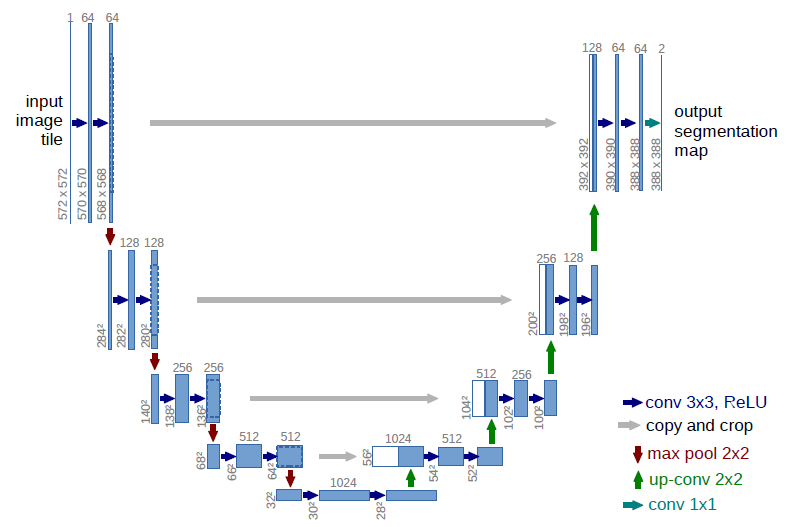

[Image reference](https://arxiv.org/abs/1505.04597)

In [ ]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

# Basic Imports

In [ ]:
# basic imports
import random
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [ ]:
ENVIRONMENT = 'colab'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
targetWidth = 320
targetHeight = 180
# dataset_path = 'dataset'
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


In [ ]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


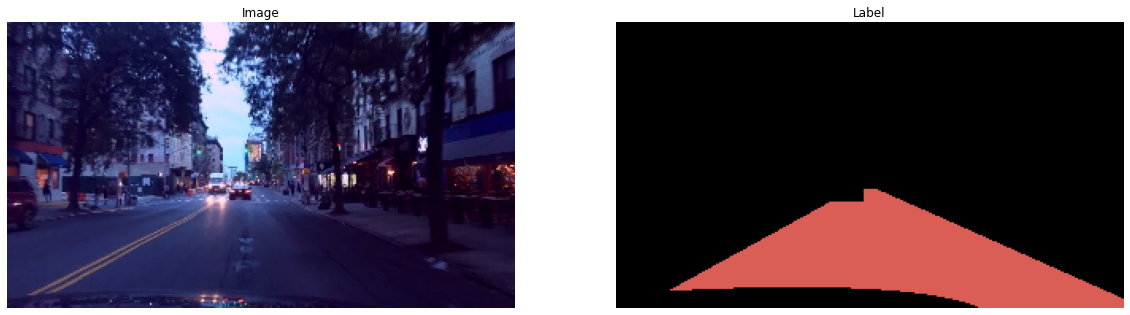

In [ ]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define a UNet model using Encoder-Decoder architecture

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride =1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torchvision.transforms.functional as TF

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, layer_channels):
        super(UNet, self).__init__()
        # Encoder layers
        self.encoder = nn.ModuleList()        
        for num_channels in layer_channels:
            self.encoder.append(double_conv(in_channels, num_channels))
            in_channels = num_channels

        # Decoder layers
        self.decoder = nn.ModuleList()        
        for num_channels in reversed(layer_channels):
            self.decoder.append(nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=2, stride=2))
            self.decoder.append(double_conv(num_channels*2, num_channels))

        # pooling layer can be reused along encoder
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # conv layer to transition from encoder to decoder
        self.bottleneck = double_conv(layer_channels[-1], layer_channels[-1]*2)
        
        # 1x1 convolution to reduce num channels to out_channels
        self.final_conv = nn.Conv2d(layer_channels[0], out_channels, kernel_size=1)
        
        
    def forward(self, x):
        # placeholder to store encoder outputs as skipconnection
        skip_connections = []
        
        # Pass input image through Encoder 
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # transition between encoder and decoder
        x = self.bottleneck(x)
        
        # we need the last skip connection first
        # so reversing the list 
        skip_connections = skip_connections[::-1]
        
        # Pass encoder output through Decoder layers
        for idx in range(0, len(self.decoder), 2):
            # upsample output and reduce channels by 2
            x = self.decoder[idx](x)
            
            # if skip connection shape doesn't match, resize
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            
            # concatenate and pass through double_conv block
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        
        # final 1x1 conv to match input size
        return self.final_conv(x)        

# 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [ ]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

## Model Training

Starting 1 epoch ...


100%|██████████| 86/86 [00:24<00:00,  3.50it/s]


Epoch: 1, trainLoss:1.02209, validationLoss:0.76222, meanIoU: 0.48
Starting 2 epoch ...


100%|██████████| 86/86 [00:24<00:00,  3.51it/s]


Epoch: 2, trainLoss:0.55699, validationLoss:0.61359, meanIoU: 0.54
Starting 3 epoch ...


100%|██████████| 86/86 [00:24<00:00,  3.51it/s]


Epoch: 3, trainLoss:0.44146, validationLoss:0.42833, meanIoU: 0.60


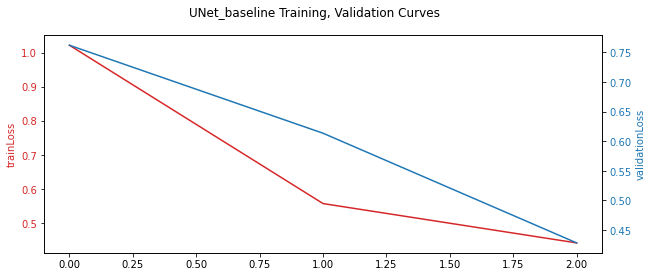

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 3
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'UNet_baseline'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=3, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:12<00:00,  3.52it/s]


Model has 0.6010111992290689 mean IoU in test set


In [ ]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


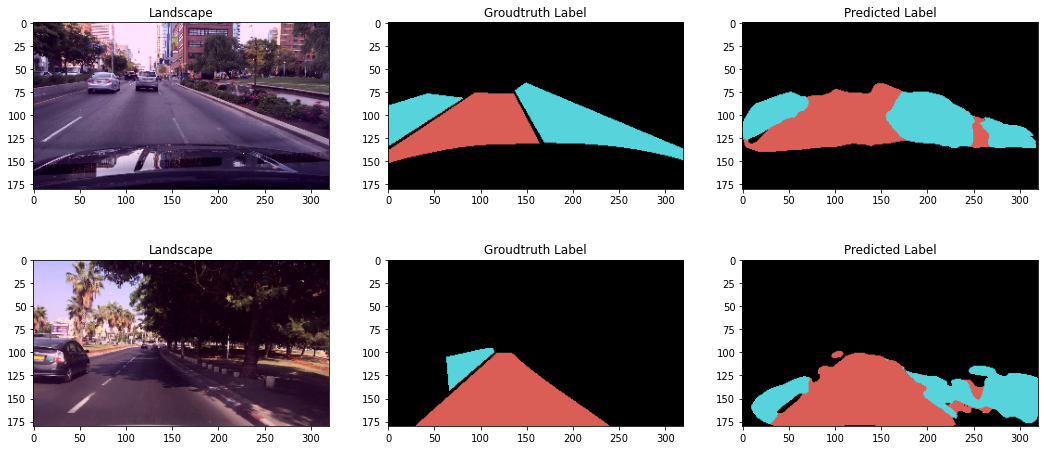

In [ ]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples)

## Test on sample video